In [1]:
import os
import glob
import numpy as np
import tensorflow as tf

from skimage import io, measure
from scipy.ndimage import zoom

def soft_one_hot(img):
    '''Rachels segmenatation is WxHxDx3 for prediction along x,y,z axis
    This function turns her index encoding to one hot and applys softmax for soft labels
    '''
    img[img==0] = 1 #cells
    img[img==100] = 0 #veins to background
    img[img==152] = 2 #epidermus
    img[img==170] = 3 #stoma
    img[img==202] = 0 #background
    img[img==255] = 0 #air to background
    imgx = tf.one_hot(img[:,:,:,0], 4)
    imgy = tf.one_hot(img[:,:,:,1], 4)
    imgz = tf.one_hot(img[:,:,:,2], 4)
    img = tf.nn.softmax(imgx+imgy+imgz)
    return img.numpy()

def merge_background_instances(mask, threshold_label=200, bg_label=0):
    '''Generates a mask, where any label below, equal the threshold_label is set to the bg_label'''
    mask[mask <= threshold_label] = bg_label
    return mask

def get_mask(instance_mask):
  '''returns a mask of foreground 1, background 0'''
  mask = np.ones_like(instance_mask)
  mask[instance_mask==0] = 0
  return mask

def rescale_data(data, zoom_factor, order=0):
    
    if any([zf!=1 for zf in zoom_factor]):
        data_shape = data.shape
        data = zoom(data, zoom_factor, order=3)
        
    return data

def calculate_flows(instance_mask, bg_label=0):
    '''Calculates Tanh of gradients pointing to the center, get gradients by coord - center'''
    
    flow_x = np.zeros(instance_mask.shape, dtype=np.float32)
    flow_y = np.zeros(instance_mask.shape, dtype=np.float32)
    flow_z = np.zeros(instance_mask.shape, dtype=np.float32)
    regions = measure.regionprops(instance_mask)
    for props in regions:
        
        if props.label == bg_label:
            continue
        
        c = props.centroid
        coords = np.where(instance_mask==props.label)
        
        flow_x[coords] = np.tanh((coords[0]-c[0])/5)
        flow_y[coords] = np.tanh((coords[1]-c[1])/5)
        flow_z[coords] = np.tanh((coords[2]-c[2])/5)
    
    return flow_x, flow_y, flow_z

def prepare_images(src_path='', target_path='', semantic_path='', identifier='*.tiff', zoom_factor=(1,1,1), channel=0, semantic_seg=False):

    image_list = glob.glob(os.path.join(src_path, identifier))
    for num_file,file in enumerate(image_list):
        
        # load the image
        processed_img = io.imread(file)     
        processed_img = processed_img.astype(np.float32)
        
        # get the desired channel, if the image is a multichannel image
        if processed_img.ndim == 4:
            processed_img = processed_img[...,channel]
        
        # rescale the image
        processed_img = rescale_data(processed_img, zoom_factor, order=3)
        
        # normalize the image
        perc1, perc2 = np.percentile(processed_img, list([0,100]))
        processed_img -= perc1
        processed_img /= (perc2-perc1)
        processed_img = np.clip(processed_img, 0, 1)
        processed_img = processed_img.astype(np.float32)
        
        # Add a channel axis
        processed_img = np.expand_dims(processed_img, axis=-1)

        if semantic_seg:
            f_name = os.path.split(file)[-1]
            semantic_mask = np.load(os.path.join(semantic_path, f_name[:-(len(identifier)-1)]+'.npy'))
            print(semantic_mask.shape)
            semantic_mask = soft_one_hot(semantic_mask)
            print(semantic_mask.shape, semantic_mask.min(), semantic_mask.max())
            processed_img = np.concatenate([processed_img, semantic_mask], axis=-1)
            print(processed_img.shape)
        
        save_name = os.path.split(file)[-1]
        save_name = os.path.join(target_path, save_name[:-(len(identifier)-1)]+'.npy')
        np.save(save_name, processed_img)

            
def prepare_masks(src_path='', target_path='', identifier='*.tiff', bg_label=0, zoom_factor=(1,1,1)):

    mask_list = glob.glob(os.path.join(src_path, identifier))
    for num_file,file in enumerate(mask_list):
        
        # load the mask
        instance_mask = io.imread(file)
        instance_mask = instance_mask.astype(np.uint16)
        
        # Alex's mask has several instanevs for the background (value below 200), here we merge them to value 0
        instance_mask = merge_background_instances(instance_mask)
        assert instance_mask.dtype == np.uint16
        
        instance_mask[instance_mask==bg_label] = 0
                        
        # rescale the mask
        instance_mask = rescale_data(instance_mask, zoom_factor, order=0)
        
        # get forground / background mask and add channel axis
        mask = get_mask(instance_mask)

        # calculate the flow field
        flow_x, flow_y, flow_z = calculate_flows(instance_mask, bg_label=bg_label)
        print('these should be the same', flow_x.shape, mask.shape)
        mask = np.stack((mask, flow_x, flow_y, flow_z), axis=3)
        
        save_name = os.path.split(file)[-1]
        save_name = os.path.join(target_path, save_name[:-(len(identifier)-1)]+'.npy')
        np.save(save_name, mask)

In [2]:
prepare_images(src_path='data/images', target_path='data/images', semantic_path='data/semantic_seg', semantic_seg=True)
prepare_masks(src_path='data/masks', target_path='data/masks')

(256, 256, 256, 3)
(256, 256, 256, 4) 0.043317165 0.8700486
(256, 256, 256, 5)
these should be the same (256, 256, 256) (256, 256, 256)


In [3]:
img = np.load('data/images/leaf3.npy')
mask = np.load('data/masks/leaf3.npy')
print(img.shape, mask.shape)

(256, 256, 256, 5) (256, 256, 256, 4)


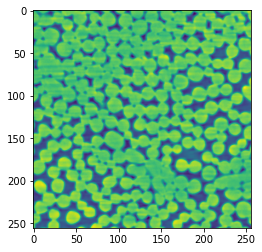

In [4]:
from matplotlib import pyplot as plt
plt.imshow(img[100,:,:,0])
plt.show()

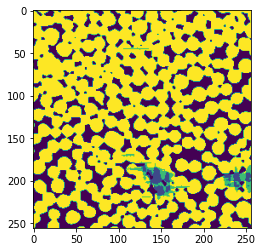

In [5]:
from matplotlib import pyplot as plt
plt.imshow(img[100,:,:,2]) # at index 1,2,3,4 is the value for the class bg,cell,epidermis,stoma
plt.show()

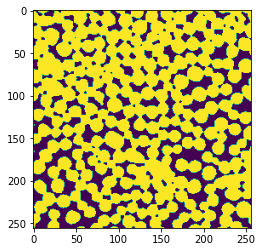

In [6]:
plt.imshow(mask[100,:,:,0])
plt.show()

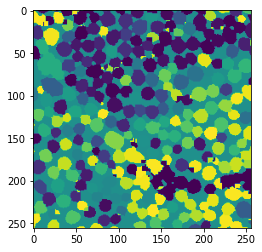

In [7]:
plt.imshow(mask[100,:,:,1])
plt.show()

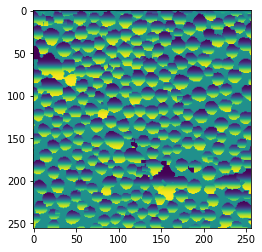

In [8]:
plt.imshow(mask[100,:,:,2])
plt.show()

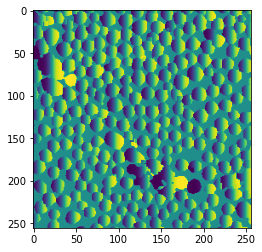

In [9]:
plt.imshow(mask[100,:,:,3])
plt.show()